In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from torch.utils.data import Dataset
import re 
from transformers import TrainingArguments
from transformers import Trainer
import matplotlib.pyplot as plt

# Load model and tokenizer for GPT-2
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Set padding token (GPT-2 does not have a defined padding token)
tokenizer.pad_token = tokenizer.eos_token

/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


First we import the packages we need. We also import the transformer mode. Note that this is one pretrained on English. 

In [4]:
# Custom dataset class for tokenizing the input data
class AnishinaabeTextDataset(Dataset):
    def __init__(self, text, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.examples = []
        
        # Split the text into chunks (e.g., by sentences or paragraphs)
        for paragraph in text.split("\n"):  # Splitting by newline for simplicity
            if paragraph.strip():  # Skipping empty lines
                tokenized_input = tokenizer(paragraph, truncation=True, max_length=max_length, padding="max_length", return_tensors="pt")
                
                # Using input text as both input and target (adjust if you want different outputs)
                self.examples.append({
                    "input_ids": tokenized_input["input_ids"].squeeze(),
                    "attention_mask": tokenized_input["attention_mask"].squeeze(),
                    "labels": tokenized_input["input_ids"].squeeze()  # Adjust this if using different outputs
                })
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        return self.examples[idx]


def clean_text(text):
    # Remove the Byte Order Mark (BOM) if it exists
    cleaned_text = text.replace('\ufeff', '')
    
    # Remove unwanted characters (if any) using regular expressions
    # For example, removing digits, parentheses, and punctuation not needed:
    cleaned_text = re.sub(r'[^\w\s\'\n]', '', cleaned_text)
    
    # Optional: Remove any extra spaces or weird line breaks
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

In [6]:
# Load the training and test data
with open('/Users/maddiegupta/Desktop/train.txt', 'r') as file:
    train_text = file.read()

with open('/Users/maddiegupta/Desktop/test.txt', 'r') as file:
    test_text = file.read()

# Create datasets
train_text = clean_text(train_text)
test_text = clean_text(test_text)
train_dataset = AnishinaabeTextDataset(train_text, tokenizer)
test_dataset = AnishinaabeTextDataset(test_text, tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",
    num_train_epochs=13,
    save_steps=10_000,
    save_total_limit=2,
    logging_dir='./logs',  # Directory for storing logs
    # play with other params (learning rate) 
    # try training from scratch and see how good in that setting 
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


In [8]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,7.515525
2,No log,7.428734
3,No log,7.360271
4,No log,7.316228
5,No log,7.281992
6,No log,7.278771
7,No log,7.286139
8,No log,7.293297
9,No log,7.297504
10,No log,7.298882


TrainOutput(global_step=13, training_loss=4.704047276423528, metrics={'train_runtime': 2014.9342, 'train_samples_per_second': 0.006, 'train_steps_per_second': 0.006, 'total_flos': 3396796416000.0, 'train_loss': 4.704047276423528, 'epoch': 13.0})

We train! 

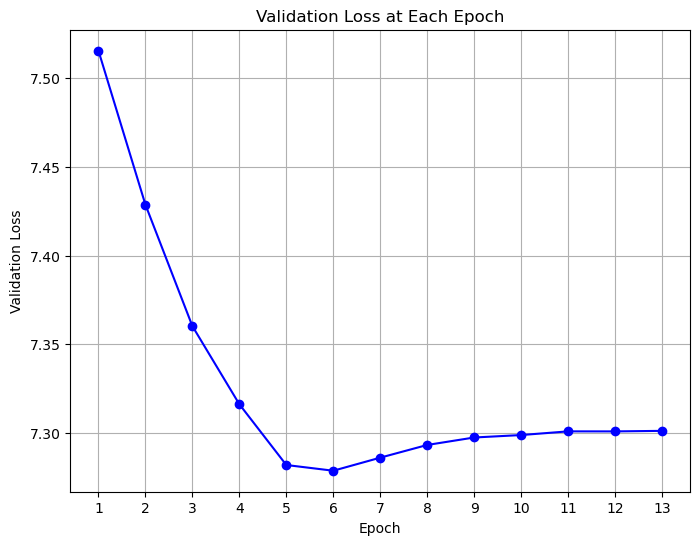

In [9]:
# Get the logs after training (example structure of logs)
training_logs = trainer.state.log_history  # Extract log history after training

# Extract validation loss and epoch numbers
epochs = []
validation_loss = []

for log in training_logs:
    if 'eval_loss' in log:  # 'eval_loss' is logged at evaluation steps
        validation_loss.append(log['eval_loss'])
        epochs.append(log['epoch'])

# Plotting validation loss at each epoch
plt.figure(figsize=(8, 6))
plt.plot(epochs, validation_loss, marker='o', linestyle='-', color='b')
plt.title('Validation Loss at Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.xticks(epochs)
plt.grid(True)
plt.show()

Here is a graphic representation of the loss by epoch. Like with the GRUs, we are looking for where loss is at a minimum. This indicates we are learning, but not memorizing. Here, this is at 6. 

In [11]:
# Load the training and test data
with open('/Users/maddiegupta/Desktop/train.txt', 'r') as file:
    train_text = file.read()

with open('/Users/maddiegupta/Desktop/test.txt', 'r') as file:
    test_text = file.read()

# Create datasets
train_text = clean_text(train_text)
test_text = clean_text(test_text)
train_dataset = AnishinaabeTextDataset(train_text, tokenizer)
test_dataset = AnishinaabeTextDataset(test_text, tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",
    num_train_epochs=6,
    save_steps=10_000,
    save_total_limit=2,
    logging_dir='./logs',  # Directory for storing logs
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


In [13]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,8.101284
2,No log,7.358704
3,No log,7.319451
4,No log,7.334649
5,No log,7.353849
6,No log,7.366873


TrainOutput(global_step=6, training_loss=4.013237635294597, metrics={'train_runtime': 59.2314, 'train_samples_per_second': 0.101, 'train_steps_per_second': 0.101, 'total_flos': 1567752192000.0, 'train_loss': 4.013237635294597, 'epoch': 6.0})

In [15]:
# Function to generate autocomplete text
def generate_autocomplete(prompt, model, tokenizer, max_length=100, device="cpu"):
    # Tokenize the input prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(device)  # Ensure tensors are on the correct device
    
    # Generate text
    outputs = model.generate(
        input_ids=inputs["input_ids"], 
        attention_mask=inputs["attention_mask"], 
        max_length=max_length,  # Maximum length of the generated text
        num_return_sequences=1,  # Number of sequences to generate
        do_sample=True,  # Enable sampling for creative generation (can be set to False for deterministic output)
        top_k=50,  # Top-k sampling
        top_p=0.95,  # Top-p (nucleus) sampling
        temperature=0.7  # Adjust temperature for randomness
    )
    
    # Decode the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

In [17]:
# Example of how to use the autocomplete function after training
prompt = "anishinaabekwe"

# Move model to the correct device (MPS or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Generate text
generated_text = generate_autocomplete(prompt, model, tokenizer, device=device)
print("Generated Text:", generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text: anishinaabekwe-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kulich-kul


As you can see, the pretrained GPT-2 works absolutely horribly. Every single word is overpowered by English, and there is no evidence it was even trained on Anishinaabemowin. 

In [20]:
#test with training text 

def evaluate_gpt2_on_test(prompt, model, tokenizer, test_text, N, device=device):
    '''
    Evaluates how well the gpt2 model performs on the test_text
            Parameters:
                    weights (list): Weights of the pretrained GRU model
                    test_text (string): Test text to compare against generated text
                    N (int): Number of characters to generate
            Returns:
                    accuracy (float): Accuracy of the model on the test text
    '''
    correct_predictions = 0
    total_predictions = 0
    
    # Choose a starting prompt from the test text
    prompt_length = 10  # You can vary this value
    for i in range(len(test_text) - prompt_length - N):
        prompt = test_text[i:i+prompt_length]
        true_text = test_text[i+prompt_length:i+prompt_length+N]
        
        # Generate text using the GRU model
        generated_text = generate_autocomplete(prompt, model, tokenizer, device=device)
        
        # Compare generated text to the actual test text
        for j in range(min(len(generated_text), len(true_text))):
            if generated_text[j] == true_text[j]:
                correct_predictions += 1
            total_predictions += 1
    
    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

In [22]:
N = 50  # Number of characters to generate
accuracy = evaluate_gpt2_on_test(prompt, model, tokenizer, test_text, N, device=device)
print(f"Model accuracy on test text: {accuracy:.2f}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Model accuracy on test text: 0.08


The accuracy is pretty bad too. At 8 percent, the English pretraining for Anishinaabemowin isn't too promising. 

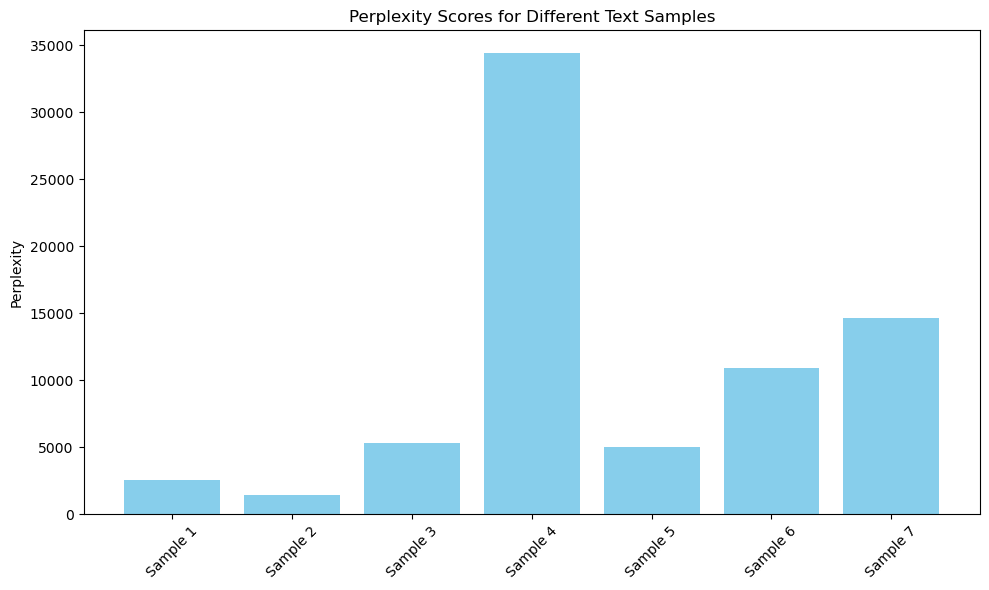

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def calculate_perplexity(model, tokenizer, texts, device="cpu"):
    model.eval()  # Set model to evaluation mode
    model.to(device)

    perplexities = []

    # Iterate over each text in the list
    for text in texts:
        # Tokenize the input text
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], labels=inputs["input_ids"])
            loss = outputs.loss

        # Perplexity is the exponentiation of the cross-entropy loss
        perplexity = torch.exp(loss).item()
        perplexities.append(perplexity)

    return perplexities

# Example Usage with a list of texts
texts = [
    "giizhibiiginan awe",
    "anishnaabemowin ikidon",
    "giigidowin minwaajimo",
    "miinawaa ningaabii'an",
    "naanaagadawendang giigidowin",
    "oshkwaakobizhinang ondaadiziyang",
    "gaye waabanjigaadeg"
    
]

# Calculate perplexities for all texts
perplexities = calculate_perplexity(model, tokenizer, texts, device)

# Plot the perplexities
plt.figure(figsize=(10, 6))
plt.bar(range(len(texts)), perplexities, color='skyblue')
plt.xticks(range(len(texts)), [f"Sample {i+1}" for i in range(len(texts))], rotation=45)
plt.ylabel("Perplexity")
plt.title("Perplexity Scores for Different Text Samples")
plt.tight_layout()
plt.show()


Our perplexity is super high, with one sample even reaching 35000. This is clearly much higher than the English text that trained the pretrained English mode. Overall, this works very poorly. 